In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W.xml
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/image_metadata_stylesheet.xsl
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/ibug/image_077.jpg
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/ibug/image_084_mirror.jpg
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/ibug/image_031.pts
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/ibug/image_092_mirror.jpg
/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_data

In [8]:
! pip install ultralytics 
import os, glob, cv2
import numpy as np
from ultralytics import YOLO 
import shutil 

In [9]:
DATA="/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset"
OUTPUT="/kaggle/working/eye_yolo"
IMG_OUT = f"{OUTPUT}/images"
LBL_OUT = f"{OUTPUT}/labels"

shutil.rmtree(OUTPUT, ignore_errors=True)
os.makedirs(IMG_OUT, exist_ok=True)
os.makedirs(LBL_OUT, exist_ok=True)

In [10]:
def load_pts(pts_path):
    pts = []
    start = False
    with open(pts_path) as f:
        for line in f:
            line = line.strip()
            if line == "{":
                start = True
                continue
            if line == "}":
                start = False
                continue
            if start:
                parts = line.split()
                if len(parts) == 2:
                    x, y = map(float, parts)
                    pts.append((x, y))
    return np.array(pts)

image_paths = sorted(glob.glob(f"{DATA}/**/*.jpg", recursive=True))

for img_path in image_paths:
    base = os.path.splitext(os.path.basename(img_path))[0]
    pts_path = img_path.replace(".jpg", ".pts")

    if not os.path.exists(pts_path):
        continue

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    pts = load_pts(pts_path)

    if pts.shape[0] != 68:
        print("Invalid landmark file:", pts_path)
        continue

    left = pts[36:42]
    right = pts[42:48]

    if left.shape[0] < 6 or right.shape[0] < 6:
        print("Skipping incomplete eye landmark:", pts_path)
        continue

    def bbox_from_pts(kps):
        x1 = np.min(kps[:,0])
        y1 = np.min(kps[:,1])
        x2 = np.max(kps[:,0])
        y2 = np.max(kps[:,1])
        return x1, y1, x2, y2

    l_x1, l_y1, l_x2, l_y2 = bbox_from_pts(left)
    r_x1, r_y1, r_x2, r_y2 = bbox_from_pts(right)

    # convert to YOLO normalized format
    def to_yolo(x1,y1,x2,y2):
        cx = (x1 + x2)/2 / w
        cy = (y1 + y2)/2 / h
        bw = (x2 - x1) / w
        bh = (y2 - y1) / h
        return cx, cy, bw, bh

    l_box = to_yolo(l_x1,l_y1,l_x2,l_y2)
    r_box = to_yolo(r_x1,r_y1,r_x2,r_y2)

    out_img_path = f"{IMG_OUT}/{base}.jpg"
    shutil.copy(img_path, out_img_path)

    out_lbl_path = f"{LBL_OUT}/{base}.txt"
    with open(out_lbl_path, "w") as f:
        f.write(f"0 {l_box[0]} {l_box[1]} {l_box[2]} {l_box[3]}\n")
        f.write(f"0 {r_box[0]} {r_box[1]} {r_box[2]} {r_box[3]}\n")





In [11]:
with open("eye_dataset.yaml", "w") as f:
    f.write(f"""
path: {OUTPUT}
train: images
val: images

names:
  0: eye
""")

In [12]:
model = YOLO("yolov8s.pt")

results = model.train(
    data="eye_dataset.yaml",
    imgsz=640,
    epochs=30,
    batch=16,
    patience=5,
)

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=eye_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrain

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2802       5604      0.964      0.885      0.945      0.711
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2


In [13]:
metrics=model.val()
print("mAP-50:", metrics.box.map50)
print("mAP 50-95:", metrics.box.map50-95)
print("Precision:", metrics.box.mp)
print("Recall:", metrics.box.mr)

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2932.7±1248.7 MB/s, size: 348.7 KB)
val: Scanning /kaggle/working/eye_yolo/labels.cache... 2802 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2802/2802 4.7Mit/s 0.0s
train: /kaggle/working/eye_yolo/images/image_057_1.jpg: corrupt JPEG restored and saved
train: /kaggle/working/eye_yolo/images/image_084.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 176/176 5.2it/s 33.9s0.2ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2802       5604      0.964      0.885      0.945      0.713
Speed: 0.7ms preprocess, 7.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
mAP-50: 0.9448762285331584
mAP 50-95: -94.05512377146684
Precision: 0.964087479751192
Recall: 0.8845467523197716


In [16]:
pred_dir = "/kaggle/working/predictions"
os.makedirs(pred_dir, exist_ok=True)

preds = model.predict(
    source=IMG_OUT,   # your images folder
    save=True,        # save annotated images
    save_txt=True,    # save YOLO txt detections
    conf=0.25         # confidence threshold
)

#print("Saved predictions in:", pred_dir)




WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2802 /kaggle/working/eye_yolo/images/100032540_1.jpg: 608x640 2 eyes, 17.4ms
image 2/2802 /kaggle/working/eye_yolo/images/100040721_1.jpg: 640x640 1 eye, 17.0ms
image 3/2802 /kaggle/working/eye_yolo/images/100040721_2.jpg: 640x640 2 eyes, 16.3ms
image 4/2802 /kaggle/working/eye_yolo/images/1002681492_1.jpg: 448x640 2 eyes, 13.7ms
image 5/2802 /kaggle/working/eye_yolo/images/1004467229_1.jpg: 544x640 2 eyes, 16.5ms
image 6/2802 /kaggle/working/e

In [28]:
import os
for root, dirs, files in os.walk("/kaggle/working/runs/detect/val"):
    print(root, "->", len([f for f in files if f.endswith(".jpg")]), "images")

/kaggle/working/runs/detect/val -> 6 images


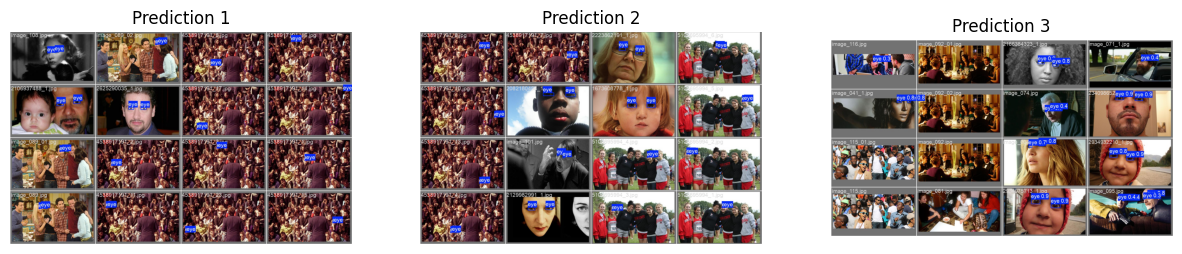

In [29]:
import cv2
import matplotlib.pyplot as plt
import glob

# Folder with YOLO validation predictions
pred_dir = "/kaggle/working/runs/detect/val"

# Get first 3 jpg images
pred_images = glob.glob(pred_dir + "/*.jpg")[:3]

# Display them
plt.figure(figsize=(15,5))
for i, img_path in enumerate(pred_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction {i+1}")
plt.show()



0: 640x640 2 eyes, 16.2ms
Speed: 3.0ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


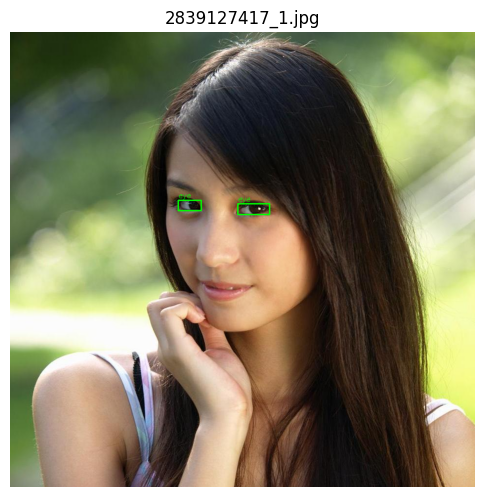


0: 640x448 2 eyes, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


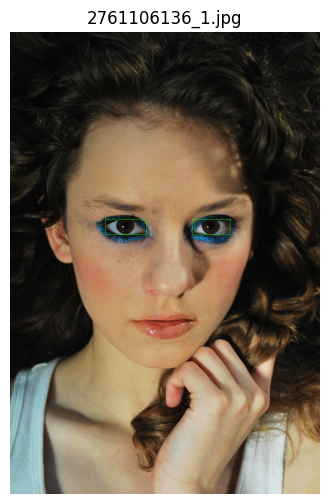


0: 448x640 2 eyes, 14.4ms
Speed: 2.9ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


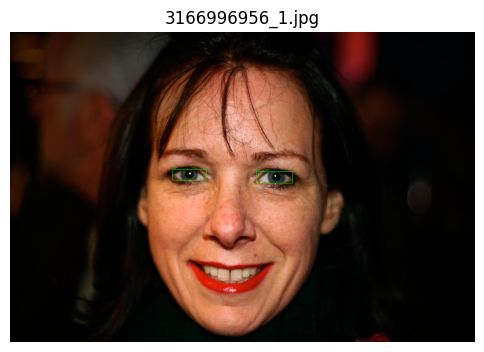

In [31]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import glob

# Load your trained YOLO model
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")  # or yolov8s.pt if fine-tuned

pred_dir = "/kaggle/working/eye_yolo/images"
pred_images = glob.glob(pred_dir + "/*.jpg")[:3]  # first 3 images

for img_path in pred_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    results = model(img)[0]  # predict on single image
    
    # Draw bounding boxes manually
    for box in results.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_rgb, "eye", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(img_path.split('/')[-1])
    plt.show()



In [46]:
def extract_eye_features(cropped_eye):
    gray = cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    # brightness
    brightness = float(np.mean(gray))

    # openness: eye height / width
    openness = float(h / w) if w != 0 else 0

    # shape: area
    area = float(h * w)

    # symmetry
    half_w = w // 2
    left = gray[:, :half_w]
    right = gray[:, w - half_w:]  # take last half_w pixels from the right
    right = cv2.flip(right, 1)

    # ensure both halves are the same shape
    min_w = min(left.shape[1], right.shape[1])
    left = left[:, :min_w]
    right = right[:, :min_w]

    symmetry = float(np.mean(cv2.absdiff(left, right)))

    return {
        "area": area,
        "openness": openness,
        "brightness": brightness,
        "symmetry": symmetry
    }


In [47]:
import pandas as pd

feature_list = []

for img_path in sorted(glob.glob(f"{IMG_OUT}/*.jpg"))[:20]:  # first 20 images
    img = cv2.imread(img_path)
    res = model(img)[0]

    for box in res.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)

        eye_crop = img[y1:y2, x1:x2]
        if eye_crop.size == 0:
            continue

        feats = extract_eye_features(eye_crop)
        feats["image"] = os.path.basename(img_path)
        feature_list.append(feats)

df = pd.DataFrame(feature_list)
df.head()


0: 608x640 2 eyes, 16.1ms
Speed: 4.1ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 1 eye, 16.9ms
Speed: 2.8ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 eyes, 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 eyes, 13.9ms
Speed: 2.6ms preprocess, 13.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 2 eyes, 16.3ms
Speed: 2.3ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 2 eyes, 16.6ms
Speed: 3.2ms preprocess, 16.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 2 eyes, 12.8ms
Speed: 2.5ms preprocess, 12.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 eyes, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x5

,area,openness,brightness,symmetry,image
0,4601.0,0.401869,84.960661,68.640632,100032540_1.jpg
1,3914.0,0.368932,72.037046,32.025800,100032540_1.jpg
2,400.0,0.250000,60.870000,13.220000,100040721_1.jpg
3,462.0,0.424242,81.374459,24.566964,100040721_2.jpg
4,259.0,0.189189,72.416988,11.396825,100040721_2.jpg


In [50]:
model.save("edm.pt")

In [51]:
import os
os.listdir("/kaggle/working/")

['yolov8s.pt',
 'predictions',
 'yolo11n.pt',
 'runs',
 '.virtual_documents',
 'eye_dataset.yaml',
 'eye_detector_model.pt',
 'edm.pt',
 'eye_yolo']